In [1]:
%matplotlib inline

In [2]:
import numpy as np
from io import StringIO
from astropy.constants import c
import matplotlib.pyplot as plt
import itertools
from astropy.coordinates import Angle
from astropy import units as u, c
from astropy.coordinates import EarthLocation, AltAz, ITRS, CartesianRepresentation

In [87]:
c_const = c.value
frequency  = 93.7e9
wavelength = c_const/frequency

In [3]:
def calc_R(H,dec):
    if np.isscalar(H):
        H = np.array([H])

    R = np.array([[np.sin(H), np.cos(H), np.zeros_like(H)],\
        [-np.sin(dec)*np.cos(H), np.sin(dec)*np.sin(H), np.cos(dec*np.ones_like(H))],\
        [np.cos(dec)*np.cos(H), -np.cos(dec)*np.sin(H), np.sin(dec*np.ones_like(H))]])

    return R

In [4]:
def _altaz_to_earthlocation(altaz):
    local_itrs = altaz.transform_to(ITRS(location=altaz.location))
    itrs = ITRS(local_itrs.cartesian + altaz.location.get_itrs().cartesian)
    return itrs.earth_location

In [5]:
def _earthlocation_to_altaz(location, reference_location):
    # See
    # https://docs.astropy.org/en/stable/coordinates/common_errors.html#altaz-calculations-for-earth-based-objects
    # for why this is necessary and we cannot just do
    # `get_itrs().transform_to(AltAz())`
    itrs_cart = location.get_itrs().cartesian
    itrs_ref_cart = reference_location.get_itrs().cartesian
    local_itrs = ITRS(itrs_cart - itrs_ref_cart, location=reference_location)
    return local_itrs.transform_to(AltAz(location=reference_location))

In [6]:
def local_to_earth_location(x, y, z, reference_location):
    cart = CartesianRepresentation(x, y, z)
    altaz = AltAz(cart, location=reference_location)
    return _altaz_to_earthlocation(altaz)

In [7]:
def earth_location_to_local_enu(location, reference_location):
    altaz = _earthlocation_to_altaz(location, reference_location)
    ned_coords =  altaz.cartesian.xyz
    enu_coords = ned_coords[1], ned_coords[0], -ned_coords[2]
    return enu_coords

In [8]:
def enu_to_local_altaz(enu_baselines, distance):
    elevation = np.arctan2(enu_baselines[0], enu_baselines[1])
    azimuth = np.arcsin(enu_baselines[2]/distance)
    return elevation, azimuth

In [9]:
""" SMALL_SIZE = 14
MEDIUM_SIZE = 15
BIGGER_SIZE = 16

plt.rcParams.update(
    {
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.texsystem": "pdflatex",  # default is xetex
    }
)

plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize """

' SMALL_SIZE = 14\nMEDIUM_SIZE = 15\nBIGGER_SIZE = 16\n\nplt.rcParams.update(\n    {\n        "font.family": "serif",\n        "text.usetex": True,\n        "pgf.rcfonts": False,\n        "pgf.texsystem": "pdflatex",  # default is xetex\n    }\n)\n\nplt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes\nplt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title\nplt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels\nplt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels\nplt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels\nplt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize '

In [10]:
antenna_config_path = r"C:\Users\matia\Desktop\B\casa-6.5.5-21-py3.8\lib\py\lib\python3.8\site-packages\casadata\__data__\alma\simmos"
dtype=[('x','f4'),('y','f4'),('z','f4'),('D','f4'),('id','S5')]

# Error en posiciones de la matriz de rotación calc_R

In [67]:
H = 0.
dec = np.radians(45)

In [70]:
R = np.array([[np.sin(H), np.cos(H), np.zeros_like(H)],\
        [-np.sin(dec)*np.cos(H), np.sin(dec)*np.sin(H), np.cos(dec*np.ones_like(H))],\
        [np.cos(dec)*np.cos(H), -np.cos(dec)*np.sin(H), np.sin(dec*np.ones_like(H))]])

In [71]:
# Forma que debería tener R
R

array([[ 0.        ,  1.        ,  0.        ],
       [-0.70710678,  0.        ,  0.70710678],
       [ 0.70710678, -0.        ,  0.70710678]])

In [66]:
# La forma que devuelve la función
calc_R(0., dec).T

array([[[ 0.        , -0.70710678,  0.70710678],
        [ 1.        ,  0.        , -0.        ],
        [ 0.        ,  0.70710678,  0.70710678]]])

In [74]:
# Reorganizando
calc_R(0., dec).transpose(2,0,1)

array([[[ 0.        ,  1.        ,  0.        ],
        [-0.70710678,  0.        ,  0.70710678],
        [ 0.70710678, -0.        ,  0.70710678]]])

 # 

Tiempo de observación CASA = 7200s - 2 horas

Tiempo de muestreo = 6 min - 0.1 horas

Frecuencia = 93.7 GHz

Ángulo horario = transit

# Caso coordenadas no están en ENU

AntennaList = vla d

Declinaciones utilizadas:

-23, -45, 90, 10


In [97]:
antenna_config_file = antenna_config_path + "\\vla.d.cfg"
data = np.loadtxt(antenna_config_file, dtype=dtype)

In [98]:
local_xyz = EarthLocation.from_geocentric(data["x"], data["y"], data["z"], u.m)

In [99]:
stack = np.column_stack((data["x"], data["y"], data["z"]))

In [100]:
telescope_center = local_xyz.of_site("vla")

In [101]:
enu_coords = np.array(earth_location_to_local_enu(local_xyz, telescope_center))

[None, Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

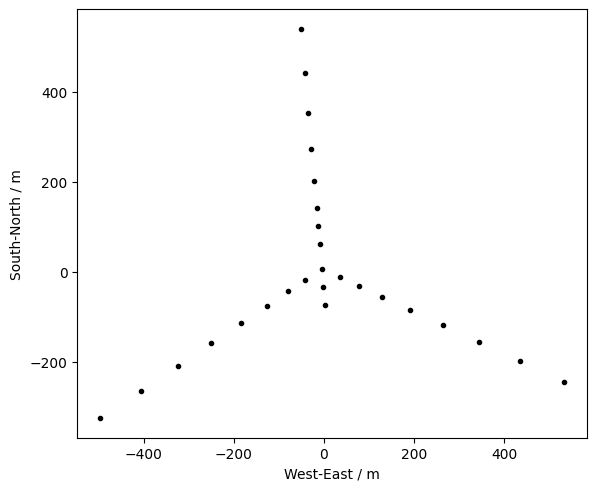

In [102]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(enu_coords[0], enu_coords[1], '.k')
ax.set(
        aspect=1,
        xlabel='West-East / m',
        ylabel='South-North / m'
)

In [103]:
# Calculate combinations of pairs of antennas in ENU coordinates
antenna_ids = np.arange(0, enu_coords.shape[1])
n_antennas = len(antenna_ids)

In [104]:
b_enu = enu_coords[..., np.newaxis] - enu_coords[:, np.newaxis,:]
b_enu = b_enu[:, ~np.eye(b_enu.shape[-1],dtype=bool)]

In [105]:
abs_b = np.sqrt(np.sum(b_enu**2, axis=0))

In [106]:
azimuth = np.arctan2(b_enu[0], b_enu[1])
elevation = np.arcsin(b_enu[2]/abs_b)

In [107]:
#Latitude of VLA 34.0790 degrees
latitude = telescope_center.to_geodetic().lat.to(u.rad).value

In [108]:
x_equatorial = np.cos(latitude) * np.sin(elevation) - np.sin(latitude) * np.cos(elevation) * np.cos(azimuth)
y_equatorial = np.cos(elevation) * np.sin(azimuth)
z_equatorial = np.sin(latitude) * np.sin(elevation) + np.cos(latitude) * np.cos(elevation) * np.cos(azimuth)

In [109]:
baselines = abs_b * np.vstack([x_equatorial, y_equatorial, z_equatorial])

In [139]:
#HA = np.arange(-0.5*15.*(np.pi/180.), 0.5*15.*(np.pi/180.), 0.1*(np.pi/180.))  # [radians]
HA = np.arange(-1, 1, 0.1) * np.pi / 12.
#dec = Angle('18:13:57.65 degrees').to(u.rad).value
dec = np.radians(10)

In [131]:
R = calc_R(0.,dec).transpose(2,0,1)

In [112]:
UV_snapshot = np.dot(R, baselines)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(UV_snapshot[:,0,:],UV_snapshot[:,1,:], c="black", marker=".")
ax.set_xlabel('u (m)') 
ax.set_ylabel('v (m)')
#ax.set_aspect('equal')

In [140]:
R_complete = calc_R(HA, dec).transpose(2,0,1)

In [141]:
UV_coverage = np.dot(R_complete, baselines)/wavelength/1000

Text(0, 0.5, '$v\\ [k\\lambda]$')

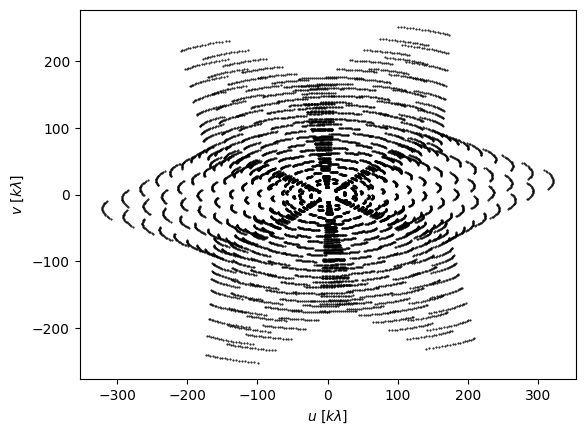

In [142]:
fig, ax = plt.subplots()
ax.scatter(UV_coverage[:, 0],UV_coverage[:,1], c="black", marker=".", s=1)
ax.set_xlabel(r'$u\ [k\lambda]$') 
ax.set_ylabel(r'$v\ [k\lambda]$')

# Caso las coordenadas ya están en ENU

AntennaList = alma cycle 1-3

Declinaciones utilizadas:

-45, 45, 10, 55

In [143]:
antenna_config_file = antenna_config_path + "\\alma.cycle1.3.cfg"
dataENU = np.loadtxt(antenna_config_file, dtype=dtype)

In [144]:
stack = np.column_stack((dataENU["x"], dataENU["y"], dataENU["z"]))

[None, Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

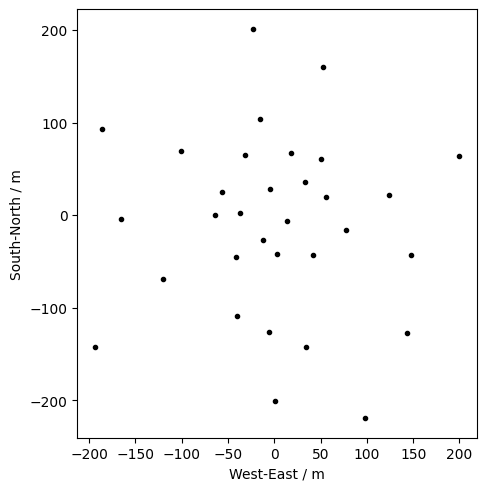

In [145]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(stack[:,0], stack[:,1], '.k')
ax.set(
        aspect=1,
        xlabel='West-East / m',
        ylabel='South-North / m'
)

In [146]:
# Calculate combinations of pairs of antennas in ENU coordinates
antenna_ids = np.arange(0, stack.shape[0])
n_antennas = len(antenna_ids)

In [147]:
b_enu = stack.T[..., np.newaxis] - stack.T[:, np.newaxis,:]
b_enu = b_enu[:, ~np.eye(b_enu.shape[-1],dtype=bool)]

In [148]:
abs_b = np.sqrt(np.sum(b_enu**2, axis=0))

In [149]:
azimuth = np.arctan2(b_enu[0], b_enu[1])
elevation = np.arcsin(b_enu[2]/abs_b)

In [150]:
telescope_center = EarthLocation.of_site("alma")

In [151]:
latitude = telescope_center.to_geodetic().lat.to(u.rad).value

In [152]:
x_equatorial = np.cos(latitude) * np.sin(elevation) - np.sin(latitude) * np.cos(elevation) * np.cos(azimuth)
y_equatorial = np.cos(elevation) * np.sin(azimuth)
z_equatorial = np.sin(latitude) * np.sin(elevation) + np.cos(latitude) * np.cos(elevation) * np.cos(azimuth)

In [153]:
baselines = abs_b * np.vstack([x_equatorial, y_equatorial, z_equatorial])

In [154]:
#HA = np.arange(-0.5*15.*(np.pi/180.), 0.5*15.*(np.pi/180.), 0.1*(np.pi/180.))  # [radians]
HA = np.arange(-1, 1, 0.1) * np.pi / 12.
dec = np.radians(10)

In [155]:
R_complete = calc_R(HA, dec).transpose(2,0,1)

In [156]:
UV_coverage = np.dot(R_complete, baselines)/wavelength/1000

Text(0, 0.5, '$v\\ [k\\lambda$]')

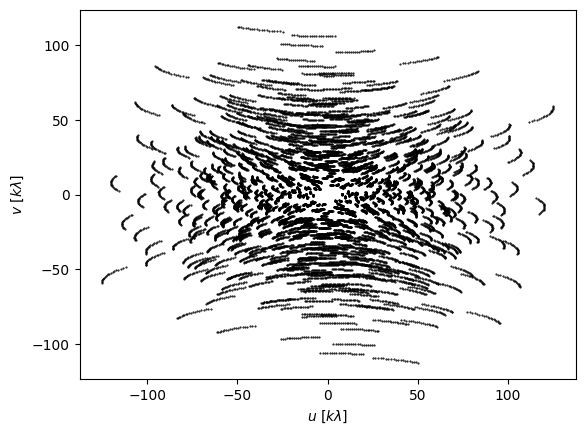

In [157]:
fig, ax = plt.subplots()
ax.scatter(UV_coverage[:, 0],UV_coverage[:,1], c="black", marker=".", s=1)
ax.set_xlabel(r'$u\ [k\lambda$]') 
ax.set_ylabel(r'$v\ [k\lambda$]')

In [45]:
""" import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

#x = np.arange(0, len(HA))
def animate(t):
    plt.cla()
    plt.scatter(UV_coverage[0:t,0,:],UV_coverage[0:t,1,:], c="black", marker=".")

matplotlib.animation.FuncAnimation(fig, animate, frames=len(HA)) """


' import matplotlib.animation\nimport matplotlib.pyplot as plt\nimport numpy as np\nplt.rcParams["animation.html"] = "jshtml"\nplt.rcParams[\'figure.dpi\'] = 150  \nplt.ioff()\nfig, ax = plt.subplots()\n\n#x = np.arange(0, len(HA))\ndef animate(t):\n    plt.cla()\n    plt.scatter(UV_coverage[0:t,0,:],UV_coverage[0:t,1,:], c="black", marker=".")\n\nmatplotlib.animation.FuncAnimation(fig, animate, frames=len(HA)) '